# Import libraries

In [1]:
import os
import sys
import datetime
import hdbscan
from termcolor import colored, cprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from os import listdir

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from chasm.glob import glob

from keras.layers import Dense, Input
from keras.models import Model
import numpy as np

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, concatenate, Input

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import random
from math import floor
from collections import Counter

scaler = StandardScaler()
disease = "ms"
scenario = "abyss"
phenotypes_labels = {
    "bc": "Breast Cancer",
    "cad": "Coronary Artery Disease",
    "ms": "Multiple Sclerosis",
    "t2d": "Type 2 Diabetes",
    "pc": "Prostate Cancer",
    "ibd": "Inflammatory Bowel Disease"
}

scenario_labels = {
    "no_cov": "no covariates",
    "abyss": "Abyss correction",
    "cov": "PCA correction",
    "abyss_cov": "Abyss + PCA as covariates"
}

# Paths

In [2]:
disease = 'ms'
scenario = "abyss"
PCs = 15

In [3]:
path_input = glob.PATH_GENO + f"/01_SNP_from_PRS/{disease}"
id_samples = pd.read_pickle(f"{glob.PATH_usefull}/id_samples.pkl")

In [4]:
id_samples

,FID,IID,PAT,MAT,SEX,PHENOTYPE
0,1000052,1000052,0,0,0,-9
1,1000133,1000133,0,0,0,-9
2,1000368,1000368,0,0,0,-9
3,1000473,1000473,0,0,0,-9
4,1000508,1000508,0,0,0,-9
...,...,...,...,...,...,...
69450,6026229,6026229,0,0,0,-9
69451,6026253,6026253,0,0,0,-9
69452,6026311,6026311,0,0,0,-9
69453,6026378,6026378,0,0,0,-9


In [5]:
list_of_bins = os.listdir(path_input)

In [6]:
snps = []
mafs = []
for bin in list_of_bins:
    path_bin = path_input + f"/{bin}"
    snp_file = [f for f in os.listdir(path_bin) if f.startswith("snp")][0]
    maf_file = [f for f in os.listdir(path_bin) if f.startswith("maf")][0]
    path_snp = path_bin + f"/{snp_file}"
    path_maf = path_bin + f"/{maf_file}"
    snps.append(pd.read_pickle(path_snp))
    mafs.append(pd.read_pickle(path_maf))

In [7]:
combined_geno = pd.concat(snps, axis=1)
combined_maf = pd.concat(mafs, axis=1)

In [8]:
combined_maf['FID'] = id_samples['FID']
combined_maf.set_index('FID', inplace=True)

In [9]:
combined_geno['FID'] = id_samples['FID']
combined_geno.set_index('FID', inplace=True)

In [10]:
combined_geno

,1:153084246:C_T_C,2:167250517:A_G_A,2:167253015:C_T_C,1:83260379:C_T_T,6:30027860:A_G_G,2:167261996:C_T_C,2:167262088:G_T_T,2:22991715:C_T_C,2:231340161:C_T_T,3:111052059:A_G_A,...,10:84064022:A_G_A,8:105993065:A_G_G,8:106034359:A_G_A,8:106032537:C_T_T,12:121084269:A_G_G,13:41009518:A_G_G,21:39361413:C_G_C,21:39361545:A_C_C,21:39362336:C_T_C,21:39367443:A_G_G
FID,,,,,,,,,,,,,,,,,,,,,
1000052,1,1,1,0,0,1,1,1,1,1,...,0,0,0,0,0,-1,-1,-1,-1,-1
1000133,0,1,1,1,1,1,1,1,0,1,...,1,0,0,0,1,0,1,1,1,1
1000368,0,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,-1,0,0,0,0
1000473,1,1,1,1,1,1,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0
1000508,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026229,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,0,1,1,1,1
6026253,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,1,1,1,1,1
6026311,1,1,1,1,1,1,1,1,1,1,...,0,-1,-1,-1,1,0,1,1,1,1


In [11]:
# Keep only the ones from training

In [12]:
#combined_geno['FID'] = combined_geno.index

In [13]:
path_pheno = glob.PATH_PHENO
pheno = pd.read_pickle(path_pheno + f"/{disease}.pkl")

In [14]:
geno = combined_geno.merge(pheno[['FID']], on='FID')

In [15]:
geno

,FID,1:153084246:C_T_C,2:167250517:A_G_A,2:167253015:C_T_C,1:83260379:C_T_T,6:30027860:A_G_G,2:167261996:C_T_C,2:167262088:G_T_T,2:22991715:C_T_C,2:231340161:C_T_T,...,10:84064022:A_G_A,8:105993065:A_G_G,8:106034359:A_G_A,8:106032537:C_T_T,12:121084269:A_G_G,13:41009518:A_G_G,21:39361413:C_G_C,21:39361545:A_C_C,21:39362336:C_T_C,21:39367443:A_G_G
0,1001137,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
1,1003518,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
2,1015489,1,0,0,0,1,0,0,1,0,...,0,1,1,1,1,0,1,1,1,1
3,1016128,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,0,0,0,0,0
4,1016963,1,1,1,1,0,1,1,0,1,...,1,0,0,0,1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,6015000,1,1,1,1,1,1,1,0,1,...,1,0,0,0,1,0,0,0,0,0
1652,6018159,1,1,1,0,1,1,1,1,1,...,1,1,1,1,0,-1,1,1,1,1
1653,6019519,1,1,1,0,1,1,1,1,0,...,1,0,0,0,1,1,1,1,1,1
1654,6019685,1,1,1,1,0,1,1,0,1,...,1,0,0,0,-1,1,1,1,1,1


# Find corresponding sumstats

In [16]:
logp_min = float(snp_file.split("_")[4])
logp_max = float(snp_file.split("_")[5].split(".pkl")[0])

In [17]:
path_input = glob.PATH_GENO + f"/02_summary_statistics/{disease}/{scenario}"

In [18]:
list_of_bins = os.listdir(path_input)
list_of_dfs = []
for bin in list_of_bins:
    try:
        temp = pd.read_pickle(path_input+f"/{bin}")
        temp['bin'] = bin.split('_')[1]
        temp = temp[temp['-logp'] > logp_min]
        temp = temp[temp['-logp'] < logp_max]
        list_of_dfs.append(temp)
    except Exception as e:
        print(e)
        print(f"Problem with bin {bin.split('_')[1]}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)

In [19]:
sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin
5892,1:244902468:A_G_A,1.052333,-0.046122,-1.146907,0.012420,-3.713366,0.000211,1,244902468,8.462182,30
32212,1:206967152:C_T_C,-1.523377,0.043336,2.687172,0.012496,3.467918,0.000538,1,206967152,7.527748,17
6617,1:37891045:A_G_G,0.000000,0.043331,0.562651,0.011737,3.691879,0.000230,1,37891045,8.378184,8
9471,1:113851065:C_T_T,1.183388,0.044281,-1.034051,0.012251,3.614554,0.000310,1,113851065,8.079324,22
6120,1:160759519:C_T_T,-0.084379,-0.054065,0.885263,0.012288,-4.399922,0.000012,1,160759519,11.371327,22
...,...,...,...,...,...,...,...,...,...,...,...
33273,22:27956628:A_C_A,2.817694,-0.043249,-2.998909,0.012202,-3.544435,0.000404,22,27956628,7.813097,16
9371,22:19653058:G_T_T,0.000000,0.046255,0.564116,0.012755,3.626444,0.000296,22,19653058,8.124934,8
10736,22:38565347:C_T_C,0.000000,0.051801,0.507578,0.013092,3.956737,0.000079,22,38565347,9.443608,2
21287,22:28371305:A_G_A,0.000000,0.044834,0.516033,0.012695,3.531593,0.000424,22,28371305,7.764845,3


# Find LD values

In [20]:
path_LD = glob.PATH_usefull + f"/LD_scores"
list_of_chroms = os.listdir(path_LD)
new_sums = []
for chrom_folder in list_of_chroms:
    chrom = chrom_folder.split("_")[1]
    path_map = path_LD + f"/chrom_{chrom}"
    file = os.listdir(path_map)[0]
    
    path_LDscores = path_map + f"/{file}"
    LDscores = pd.read_pickle(path_LDscores)

    temp_sum = sumstat[sumstat['#CHROM'] == int(chrom)]
    temp_sum = temp_sum.copy()
    
    # Now, you can safely modify it without pandas raising a SettingWithCopyWarning
    temp_sum.loc[:, 'ID'] = temp_sum['snp'].str[:-2]
    new_sums.append(temp_sum.merge(LDscores[['ID','LD_score']], on='ID'))

In [21]:
sumstat = pd.concat(new_sums, axis=0, ignore_index=True)

In [22]:
sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin,ID,LD_score
0,19:35500470:A_G_G,0.000000,0.047491,0.551774,0.012701,3.739020,0.000191,19,35500470,8.563076,7,19:35500470:A_G,8.231222
1,19:35502111:A_C_C,0.000000,0.048263,0.555832,0.012683,3.805358,0.000147,19,35502111,8.826737,7,19:35502111:A_C,8.198009
2,19:35501051:C_T_T,0.000000,0.048920,0.555748,0.012665,3.862699,0.000116,19,35501051,9.057911,7,19:35501051:C_T,8.229897
3,19:11270867:C_T_T,-0.468644,0.043465,1.330951,0.012348,3.520006,0.000443,19,11270867,7.721410,17,19:11270867:C_T,8.403742
4,19:5387039:C_T_C,1.018555,-0.044643,-0.616249,0.012438,-3.589204,0.000341,19,5387039,7.982551,11,19:5387039:C_T,1.985760
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,21:27465597:C_T_T,-0.300217,-0.042991,1.055699,0.012354,-3.480072,0.000514,21,27465597,7.572710,17,21:27465597:C_T,21.987683
1539,21:39362336:C_T_C,1.928129,-0.048955,-2.080124,0.012334,-3.969256,0.000075,21,39362336,9.495546,21,21:39362336:C_T,14.951338
1540,21:39367443:A_G_G,2.155550,-0.049802,-2.403078,0.012328,-4.039877,0.000056,21,39367443,9.791383,21,21:39367443:A_G,14.924072
1541,21:39372634:A_G_A,0.227904,-0.053156,0.413386,0.012447,-4.270506,0.000021,21,39372634,10.789627,22,21:39372634:A_G,14.680419


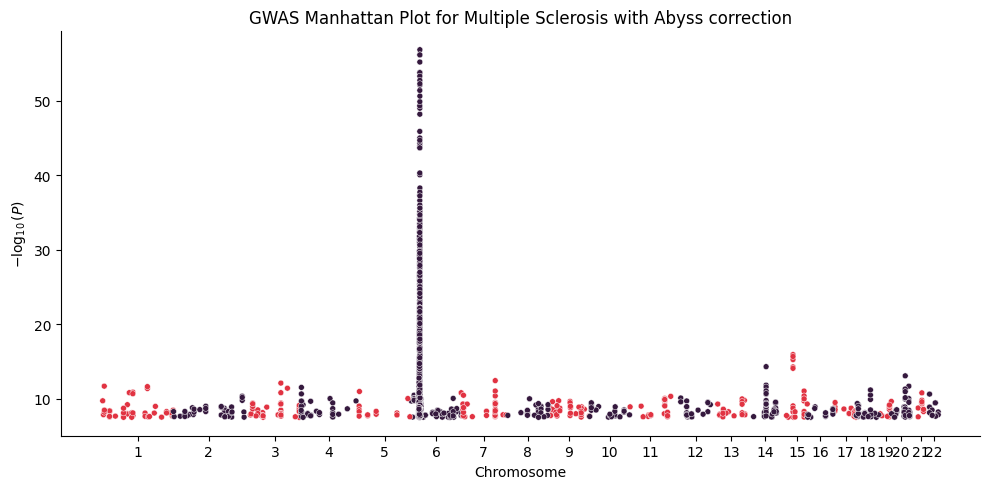

In [23]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()

# Merged genotype with summary stat and LD data

In [24]:
FIDs = geno['FID']

In [25]:
geno_transposed = geno.T
geno_transposed['snp'] = geno_transposed.index

In [26]:
merged_df = geno_transposed.merge(sumstat[['snp','beta_snp','POS','LD_score']], on='snp', how='inner')

In [27]:
merged_df

,0,1,2,3,4,5,6,7,8,9,...,1650,1651,1652,1653,1654,1655,snp,beta_snp,POS,LD_score
0,1,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1:153084246:C_T_C,0.043755,153084246,12.359316
1,1,1,0,1,1,0,1,1,1,1,...,1,1,1,1,1,1,2:167250517:A_G_A,0.042620,167250517,12.005121
2,1,1,0,1,1,0,1,1,1,1,...,1,1,1,1,1,1,2:167253015:C_T_C,0.042619,167253015,12.008079
3,1,1,0,1,1,1,1,1,1,0,...,1,1,0,0,1,1,1:83260379:C_T_T,0.044146,83260379,9.533248
4,1,1,1,1,0,1,1,0,1,1,...,1,1,1,1,0,1,6:30027860:A_G_G,-0.048634,30027860,33.459689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,0,0,0,0,-1,-1,1,0,1,0,...,1,0,-1,1,1,0,13:41009518:A_G_G,-0.044139,41009518,3.619271
1539,0,0,1,0,-1,0,1,-1,0,0,...,1,0,1,1,1,1,21:39361413:C_G_C,-0.048449,39361413,14.939757
1540,0,0,1,0,-1,0,1,-1,0,0,...,1,0,1,1,1,1,21:39361545:A_C_C,-0.048454,39361545,14.948020
1541,0,0,1,0,-1,0,1,-1,0,0,...,1,0,1,1,1,1,21:39362336:C_T_C,-0.048955,39362336,14.951338


In [28]:
column_names = merged_df['snp']
merged_df = merged_df.T
merged_df.columns = column_names

In [29]:
merged_df.index = list(FIDs) + ['snp','beta_snp','POS','LD_score']

In [30]:
merged_df

snp,1:153084246:C_T_C,2:167250517:A_G_A,2:167253015:C_T_C,1:83260379:C_T_T,6:30027860:A_G_G,2:167261996:C_T_C,2:167262088:G_T_T,2:22991715:C_T_C,2:231340161:C_T_T,3:111052059:A_G_A,...,10:84064022:A_G_A,8:105993065:A_G_G,8:106034359:A_G_A,8:106032537:C_T_T,12:121084269:A_G_G,13:41009518:A_G_G,21:39361413:C_G_C,21:39361545:A_C_C,21:39362336:C_T_C,21:39367443:A_G_G
1001137,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
1003518,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
1015489,1,0,0,0,1,0,0,1,0,1,...,0,1,1,1,1,0,1,1,1,1
1016128,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,0,0,0,0,0
1016963,1,1,1,1,0,1,1,0,1,1,...,1,0,0,0,1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026229,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,0,1,1,1,1
snp,1:153084246:C_T_C,2:167250517:A_G_A,2:167253015:C_T_C,1:83260379:C_T_T,6:30027860:A_G_G,2:167261996:C_T_C,2:167262088:G_T_T,2:22991715:C_T_C,2:231340161:C_T_T,3:111052059:A_G_A,...,10:84064022:A_G_A,8:105993065:A_G_G,8:106034359:A_G_A,8:106032537:C_T_T,12:121084269:A_G_G,13:41009518:A_G_G,21:39361413:C_G_C,21:39361545:A_C_C,21:39362336:C_T_C,21:39367443:A_G_G
beta_snp,0.043755,0.04262,0.042619,0.044146,-0.048634,0.044031,0.044744,0.041829,-0.043349,0.044284,...,0.047253,0.046327,0.04296,0.043983,-0.04527,-0.044139,-0.048449,-0.048454,-0.048955,-0.049802
POS,153084246,167250517,167253015,83260379,30027860,167261996,167262088,22991715,231340161,111052059,...,84064022,105993065,106034359,106032537,121084269,41009518,39361413,39361545,39362336,39367443


In [31]:
# Extract chromosome numbers and group columns
chromosome_to_columns = {}
for col in merged_df.columns:
    chromosome = col.split(':')[0]
    if chromosome not in chromosome_to_columns:
        chromosome_to_columns[chromosome] = []
    chromosome_to_columns[chromosome].append(col)

# Split into separate DataFrames based on chromosome
chromosome_dfs = {}
for chromosome, cols in chromosome_to_columns.items():
    chromosome_dfs[chromosome] = merged_df[cols]

# Order in LD blocks

In [32]:
merged_df = []
scaled_dfs = []
for chrom_key in chromosome_dfs.keys():
    genos_with_cov = chromosome_dfs[chrom_key]
    snp_names = np.array(genos_with_cov.T['snp'])
    positions = np.array(genos_with_cov.T['POS'])
    ld_scores = np.array(genos_with_cov.T['LD_score'])
    beta_snp = np.array(genos_with_cov.T['beta_snp'])
    columns_to_drop = ['snp', 'POS','LD_score','beta_snp']
    genos_trans = genos_with_cov.T.drop(columns=columns_to_drop)

    ld_score_df = pd.DataFrame({'snp': snp_names, 'LD_score': ld_scores, 'POS': positions, 'beta':beta_snp})
    # Apply HDBSCAN for clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)  # you can adjust the min_cluster_size as needed
    scaled_df = scaler.fit_transform(ld_score_df[['LD_score','POS','beta']])
    scaled_dfs.append(scaled_df)
    cluster_labels = clusterer.fit_predict(np.array(scaled_df))

    genos_trans['clusters'] = cluster_labels
    genos_trans['LD'] = ld_scores
    genos_trans['POS'] = positions
    genos_trans['beta'] = beta_snp
    genos_trans['chrom'] = chrom_key
    merged_df.append(genos_trans)

In [33]:
merged_df = pd.concat(merged_df, axis=0)

In [34]:
merged_df

,1001137,1003518,1015489,1016128,1016963,1018183,1020066,1020358,1021805,1023372,...,6015000,6018159,6019519,6019685,6026229,clusters,LD,POS,beta,chrom
snp,,,,,,,,,,,,,,,,,,,,,
1:153084246:C_T_C,1,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,12.359316,153084246,0.043755,1
1:83260379:C_T_T,1,1,0,1,1,1,1,1,1,0,...,1,0,0,1,1,0,9.533248,83260379,0.044146,1
1:113246630:A_G_G,1,0,1,1,1,1,1,1,0,1,...,1,-1,1,1,1,0,8.283354,113246630,0.051676,1
1:113167536:A_G_G,1,0,1,1,1,1,1,1,0,1,...,1,0,1,1,1,0,7.664674,113167536,0.045157,1
1:82906859:C_T_T,1,0,1,1,1,1,1,0,1,1,...,0,1,0,-1,-1,0,11.645046,82906859,0.043917,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13:103658646:G_T_G,0,1,1,0,1,0,1,0,0,0,...,1,1,0,1,1,1,14.1436,103658646,-0.042539,13
13:30380407:C_T_T,1,1,0,1,1,0,0,1,1,1,...,1,1,1,1,0,-1,12.095687,30380407,-0.043908,13
13:30338359:C_T_T,1,1,0,1,1,0,0,1,1,1,...,1,1,1,1,0,1,11.802815,30338359,-0.043904,13


# For the sake of visual understanding plot the snps

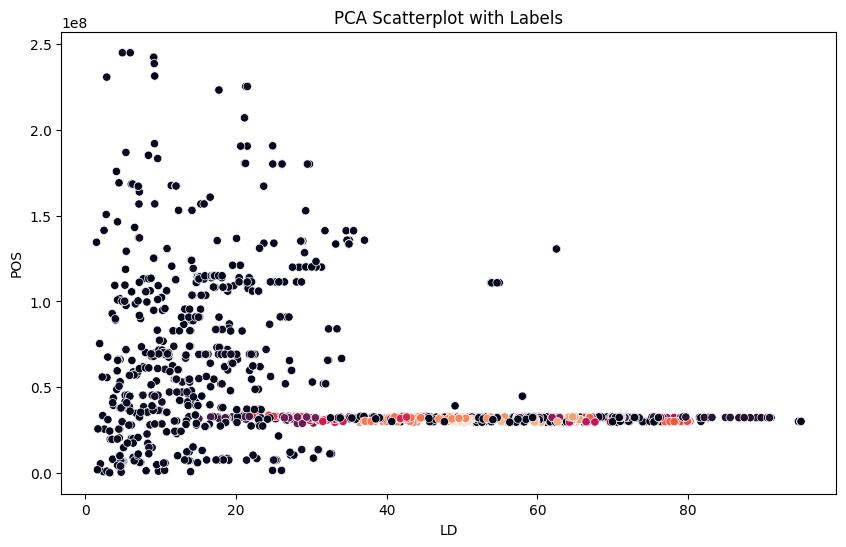

In [36]:
# Create a seaborn scatterplot

plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(x='LD', y='POS', hue='clusters', palette='rocket', data=merged_df, legend= False)



# Enhancing the plot

scatter.set_title('PCA Scatterplot with Labels')


plt.show()

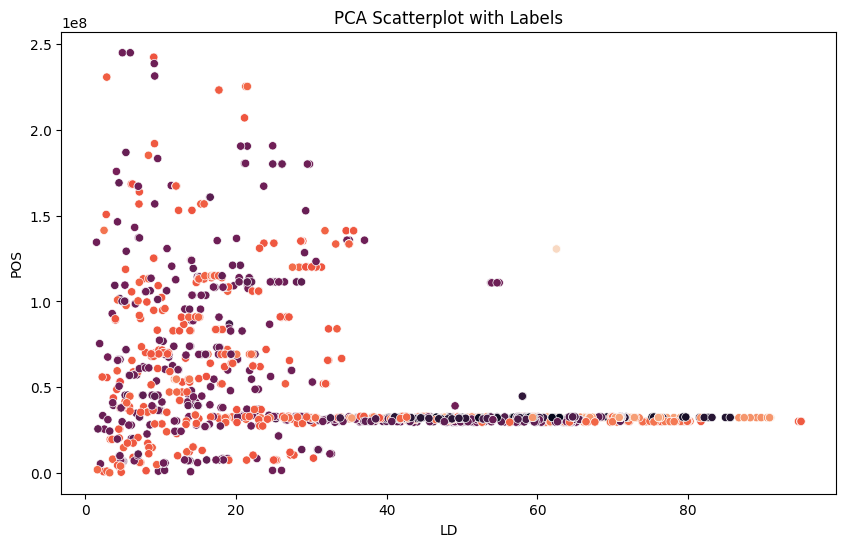

In [39]:
# Create a seaborn scatterplot

plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(x='LD', y='POS', hue='beta', palette='rocket', data=merged_df, legend= False)

# Enhancing the plot

scatter.set_title('PCA Scatterplot with Labels')


plt.show()

In [40]:
sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin,ID,LD_score,cumulative_pos,SNP number,color
0,19:35500470:A_G_G,0.000000,0.047491,0.551774,0.012701,3.739020,0.000191,19,35500470,8.563076,7,19:35500470:A_G,8.231222,2581918261,0,"(0.20973515, 0.09747934, 0.24238489)"
1,19:35502111:A_C_C,0.000000,0.048263,0.555832,0.012683,3.805358,0.000147,19,35502111,8.826737,7,19:35502111:A_C,8.198009,2581919902,1,"(0.20973515, 0.09747934, 0.24238489)"
2,19:35501051:C_T_T,0.000000,0.048920,0.555748,0.012665,3.862699,0.000116,19,35501051,9.057911,7,19:35501051:C_T,8.229897,2581918842,2,"(0.20973515, 0.09747934, 0.24238489)"
3,19:11270867:C_T_T,-0.468644,0.043465,1.330951,0.012348,3.520006,0.000443,19,11270867,7.721410,17,19:11270867:C_T,8.403742,2557688658,3,"(0.20973515, 0.09747934, 0.24238489)"
4,19:5387039:C_T_C,1.018555,-0.044643,-0.616249,0.012438,-3.589204,0.000341,19,5387039,7.982551,11,19:5387039:C_T,1.985760,2551804830,4,"(0.20973515, 0.09747934, 0.24238489)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,21:27465597:C_T_T,-0.300217,-0.042991,1.055699,0.012354,-3.480072,0.000514,21,27465597,7.572710,17,21:27465597:C_T,21.987683,2675804598,1538,"(0.20973515, 0.09747934, 0.24238489)"
1539,21:39362336:C_T_C,1.928129,-0.048955,-2.080124,0.012334,-3.969256,0.000075,21,39362336,9.495546,21,21:39362336:C_T,14.951338,2687701337,1539,"(0.20973515, 0.09747934, 0.24238489)"
1540,21:39367443:A_G_G,2.155550,-0.049802,-2.403078,0.012328,-4.039877,0.000056,21,39367443,9.791383,21,21:39367443:A_G,14.924072,2687706444,1540,"(0.20973515, 0.09747934, 0.24238489)"
1541,21:39372634:A_G_A,0.227904,-0.053156,0.413386,0.012447,-4.270506,0.000021,21,39372634,10.789627,22,21:39372634:A_G,14.680419,2687711635,1541,"(0.20973515, 0.09747934, 0.24238489)"


In [41]:
merged_df

,1001137,1003518,1015489,1016128,1016963,1018183,1020066,1020358,1021805,1023372,...,6015000,6018159,6019519,6019685,6026229,clusters,LD,POS,beta,chrom
snp,,,,,,,,,,,,,,,,,,,,,
1:153084246:C_T_C,1,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,12.359316,153084246,0.043755,1
1:83260379:C_T_T,1,1,0,1,1,1,1,1,1,0,...,1,0,0,1,1,0,9.533248,83260379,0.044146,1
1:113246630:A_G_G,1,0,1,1,1,1,1,1,0,1,...,1,-1,1,1,1,0,8.283354,113246630,0.051676,1
1:113167536:A_G_G,1,0,1,1,1,1,1,1,0,1,...,1,0,1,1,1,0,7.664674,113167536,0.045157,1
1:82906859:C_T_T,1,0,1,1,1,1,1,0,1,1,...,0,1,0,-1,-1,0,11.645046,82906859,0.043917,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13:103658646:G_T_G,0,1,1,0,1,0,1,0,0,0,...,1,1,0,1,1,1,14.1436,103658646,-0.042539,13
13:30380407:C_T_T,1,1,0,1,1,0,0,1,1,1,...,1,1,1,1,0,-1,12.095687,30380407,-0.043908,13
13:30338359:C_T_T,1,1,0,1,1,0,0,1,1,1,...,1,1,1,1,0,1,11.802815,30338359,-0.043904,13


In [48]:
temp_sumstat = pd.merge(sumstat, merged_df[['clusters']], on='snp', how='inner')
temp_sumstat['labels'] = temp_sumstat['#CHROM'].astype(str) + '_' + temp_sumstat['clusters'].astype(str)

In [49]:
temp_sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin,ID,LD_score,cumulative_pos,SNP number,color,clusters,labels
0,19:35500470:A_G_G,0.000000,0.047491,0.551774,0.012701,3.739020,0.000191,19,35500470,8.563076,7,19:35500470:A_G,8.231222,2581918261,0,"(0.20973515, 0.09747934, 0.24238489)",-1,19_-1
1,19:35502111:A_C_C,0.000000,0.048263,0.555832,0.012683,3.805358,0.000147,19,35502111,8.826737,7,19:35502111:A_C,8.198009,2581919902,1,"(0.20973515, 0.09747934, 0.24238489)",-1,19_-1
2,19:35501051:C_T_T,0.000000,0.048920,0.555748,0.012665,3.862699,0.000116,19,35501051,9.057911,7,19:35501051:C_T,8.229897,2581918842,2,"(0.20973515, 0.09747934, 0.24238489)",-1,19_-1
3,19:11270867:C_T_T,-0.468644,0.043465,1.330951,0.012348,3.520006,0.000443,19,11270867,7.721410,17,19:11270867:C_T,8.403742,2557688658,3,"(0.20973515, 0.09747934, 0.24238489)",-1,19_-1
4,19:5387039:C_T_C,1.018555,-0.044643,-0.616249,0.012438,-3.589204,0.000341,19,5387039,7.982551,11,19:5387039:C_T,1.985760,2551804830,4,"(0.20973515, 0.09747934, 0.24238489)",-1,19_-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,21:27465597:C_T_T,-0.300217,-0.042991,1.055699,0.012354,-3.480072,0.000514,21,27465597,7.572710,17,21:27465597:C_T,21.987683,2675804598,1538,"(0.20973515, 0.09747934, 0.24238489)",-1,21_-1
1539,21:39362336:C_T_C,1.928129,-0.048955,-2.080124,0.012334,-3.969256,0.000075,21,39362336,9.495546,21,21:39362336:C_T,14.951338,2687701337,1539,"(0.20973515, 0.09747934, 0.24238489)",-1,21_-1
1540,21:39367443:A_G_G,2.155550,-0.049802,-2.403078,0.012328,-4.039877,0.000056,21,39367443,9.791383,21,21:39367443:A_G,14.924072,2687706444,1540,"(0.20973515, 0.09747934, 0.24238489)",-1,21_-1
1541,21:39372634:A_G_A,0.227904,-0.053156,0.413386,0.012447,-4.270506,0.000021,21,39372634,10.789627,22,21:39372634:A_G,14.680419,2687711635,1541,"(0.20973515, 0.09747934, 0.24238489)",-1,21_-1


In [50]:
temp_sumstat['#CHROM'].unique()

array([19,  6, 20, 22, 17,  9, 10,  7, 18, 15, 12, 11, 13,  3,  1,  2,  4,
        5,  8, 16, 14, 21])

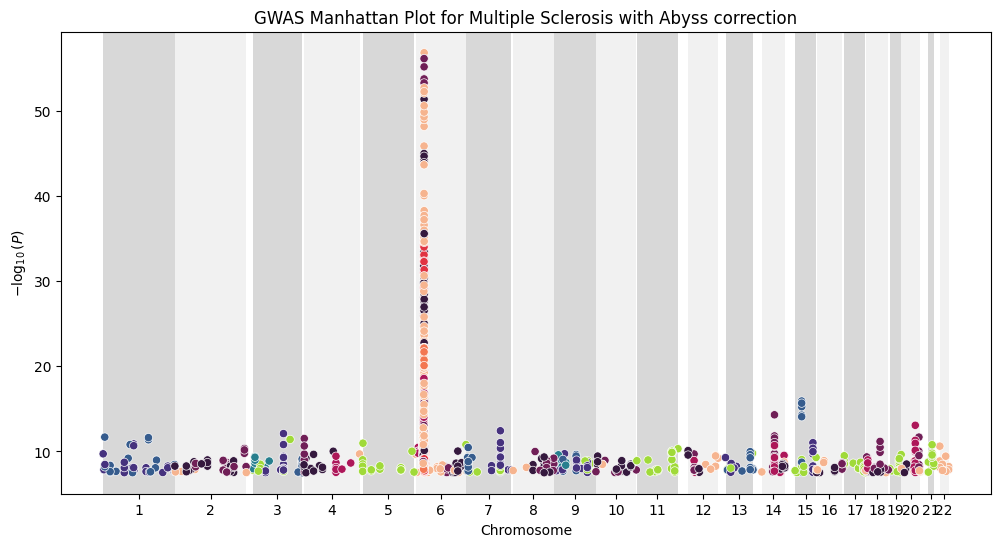

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define two palettes

even_palette = sns.color_palette("rocket")  # Lighter palette for even chromosomes
odd_palette = sns.color_palette("viridis")     # Darker palette for odd chromosomes

# Define background colors for segments
bg_color_even = "lightgrey"  # Background color for even segments
bg_color_odd = "grey"        # Background color for odd segments

# Create a figure for the Manhattan plot
plt.figure(figsize=(12, 6))

# Get start, end positions and midpoints for each chromosome
chromosomes = np.sort(temp_sumstat['#CHROM'].unique())
chrom_midpoints = []
start_end_positions = []
for chrom in chromosomes:
    start = temp_sumstat[temp_sumstat['#CHROM'] == chrom]['cumulative_pos'].min()
    end = temp_sumstat[temp_sumstat['#CHROM'] == chrom]['cumulative_pos'].max()
    midpoints = (start + end) / 2
    chrom_midpoints.append(midpoints)
    start_end_positions.append((start, end))

# Add a background color for each chromosome segment
for i, (start, end) in enumerate(start_end_positions):
    chrom = chromosomes[i]
    plt.axvspan(start, end, facecolor=bg_color_even if chrom % 2 == 0 else bg_color_odd, alpha=0.3)

# Plot the data
sns.scatterplot(
    data=temp_sumstat,
    x='cumulative_pos',
    y='-logp',
    hue='labels',
    palette={label: (even_palette if int(label.split('_')[0]) % 2 == 0 else odd_palette)[int(label.split('_')[1]) % len(even_palette)] for label in temp_sumstat['labels'].unique()},
    legend=False
)

# Set title and axis labels
plt.title(f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
plt.xlabel("Chromosome")
plt.ylabel(r"$-\log_{10}(P)$")

# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(chromosomes)  # Reversing the order of chromosomes
plt.xticks(chrom_midpoints, chrom_labels)

# Set the tick labels at a 45-degree angle
plt.xticks(rotation=0)

# Show the plot
plt.show()


# Create tiny feed forward models

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

In [58]:
from tensorflow.keras.regularizers import l2

In [59]:
l2_lambda = 0.01

In [60]:
id_samples

,FID,IID,PAT,MAT,SEX,PHENOTYPE
0,1000052,1000052,0,0,0,-9
1,1000133,1000133,0,0,0,-9
2,1000368,1000368,0,0,0,-9
3,1000473,1000473,0,0,0,-9
4,1000508,1000508,0,0,0,-9
...,...,...,...,...,...,...
69450,6026229,6026229,0,0,0,-9
69451,6026253,6026253,0,0,0,-9
69452,6026311,6026311,0,0,0,-9
69453,6026378,6026378,0,0,0,-9


In [61]:
path_pheno = glob.PATH_PHENO
pheno = pd.read_pickle(path_pheno + f"/{disease}.pkl")

In [62]:
pheno

,FID,IID,phenotype
0,4540233,4540233,1
1,2760516,2760516,0
2,3531707,3531707,1
3,5782214,5782214,0
4,2078114,2078114,1
...,...,...,...
1651,2732165,2732165,1
1652,6019519,6019519,1
1653,3019060,3019060,1
1654,1177150,1177150,1


In [91]:
snps_array = []
for (chrom, cluster), group_df in merged_df.groupby(['chrom', 'clusters']):
    temp = group_df.T
    temp['FID'] = temp.index
    temp = pd.merge(temp , pheno[['FID','phenotype']], on='FID', how='inner')
    temp = temp.T
    temp['beta'] = list(group_df['beta']) + ['NaN','NaN']
    temp = temp.T
    snps_array.append(temp)

In [103]:
class CustomDenseLayer(Dense):
    def __init__(self, units, betas, l2_lambda=0.01, **kwargs):
        super().__init__(units, kernel_regularizer=l2(l2_lambda), **kwargs)
        self.initial_weights = betas

    def build(self, input_shape):
        super().build(input_shape)
        self.set_weights([self.initial_weights.reshape(-1, 1)])

# Your snps_array and other data preparations remain the same

# Define a list to hold your sub-models
sub_models = []
X_trains = []
X_tests = []
genos = []
for snps_cluster in snps_array:
    #betas = np.array(snps_cluster.iloc[-1])


    geno = snps_cluster.drop(columns=["FID",'phenotype'])
    betas = np.array(geno.T['beta'])
    geno = geno.T.drop(columns=['beta']).T
    pheno = snps_cluster.T.drop(columns=['beta']).T[['phenotype']]

    #pheno = pheno.sample(frac=1)
    len_test = round(pheno.shape[0] / 10) * 3
    len_train = pheno.shape[0] - len_test
    y_train = pheno[['phenotype']].head(len_train)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    y_test = pheno[['phenotype']].tail(len_test)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
    
    X_train = geno.head(len_train)
    X_train = scaler.fit_transform(X_train)
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_trains.append(X_train)
    X_test = geno.tail(len_test)
    X_test = scaler.fit_transform(X_test)
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    X_tests.append(X_test)

    # Create the Keras sub-model
    model_input = Input(shape=(geno.shape[1],))
    genos.append(geno)
    custom_layer = CustomDenseLayer(1, betas, use_bias=False)(model_input)
    sub_model = Model(inputs=model_input, outputs=custom_layer)
    
    sub_models.append(sub_model)

# Concatenate the outputs of the sub-models
concatenated_outputs = concatenate([model.output for model in sub_models])

# Add the final trainable dense layer
final_layer = Dense(1, activation='linear', kernel_regularizer=l2(l2_lambda))(concatenated_outputs)

# Create the final model
final_model = Model(inputs=[model.input for model in sub_models], outputs=final_layer)

# Compile the final model
final_model.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = final_model.fit(X_trains, y_train, epochs=30, batch_size=32, validation_data=(X_tests, y_test), callbacks=[early_stopping_callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/30
37/37 [==============================] - 7s 35ms/step - loss: 0.7275 - val_loss: 0.5357
Epoch 2/30
37/37 [==============================] - 0s 13ms/step - loss: 0.4807 - val_loss: 0.4240
Epoch 3/30
37/37 [==============================] - 0s 11ms/step - loss: 0.3885 - val_loss: 0.3635
Epoch 4/30
37/37 [==============================] - 0s 10ms/step - loss: 0.3324 - val_loss: 0.3214
Epoch 5/30
37/37 [==============================] - 0s 9ms/step - loss: 0.2916 - val_loss: 0.2872
Epoch 6/30
37/37 [==============================] - 0s 10ms/step - loss: 0.2580 - val_loss: 0.2587
Epoch 7/30
37/37 [==============================] - 0s 11ms/step - loss: 0.2308 - val_loss: 0.2347
Epoch 8/30
37/37 [==============================] - 0s 10ms/step - loss: 0.2084 - val_loss: 0.2198
Epoch 9/30
37/37 [==============================] - 0s 10ms/step - loss: 0.1884 - val_loss: 0.2023
Epoch 10/30
37/37 [==============================] - 0s 9ms/step - loss: 0.1732 - val_loss: 0.1855
Epoch 11/30

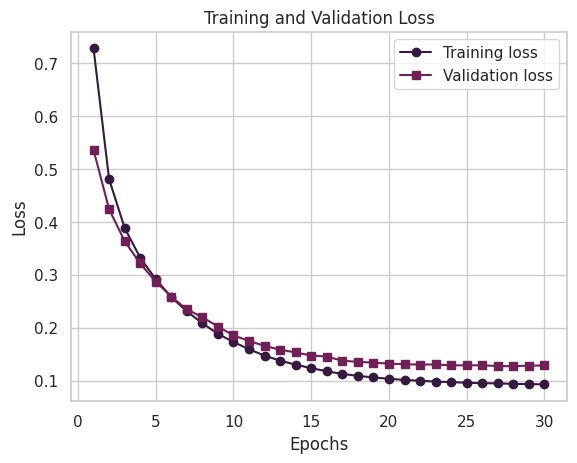

In [104]:
# Setting the style to 'rocket' from seaborn
sns.set(style="whitegrid", palette="rocket")

epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'o-', label='Training loss')
plt.plot(epochs, val_loss, 's-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Holdout set

In [105]:
pheno = pd.read_pickle(path_pheno + f"/{disease}_holdout.pkl")

In [106]:
pheno

,FID,IID,phenotype
0,2802056,2802056,1
1,5250867,5250867,1
2,4853023,4853023,0
3,5878744,5878744,0
4,3470946,3470946,1
...,...,...,...
707,5430392,5430392,0
708,2249802,2249802,0
709,1599198,1599198,0
710,1297188,1297188,1


In [114]:
geno = combined_geno.merge(pheno[['FID']], on='FID')

In [115]:
geno

,FID,1:153084246:C_T_C,2:167250517:A_G_A,2:167253015:C_T_C,1:83260379:C_T_T,6:30027860:A_G_G,2:167261996:C_T_C,2:167262088:G_T_T,2:22991715:C_T_C,2:231340161:C_T_T,...,10:84064022:A_G_A,8:105993065:A_G_G,8:106034359:A_G_A,8:106032537:C_T_T,12:121084269:A_G_G,13:41009518:A_G_G,21:39361413:C_G_C,21:39361545:A_C_C,21:39362336:C_T_C,21:39367443:A_G_G
0,1001245,1,1,1,1,0,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
1,1004004,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,1,1,1,1
2,1010025,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,0,0,0,0,0
3,1012978,1,1,1,1,0,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0
4,1020924,1,1,1,0,1,1,1,1,0,...,0,-1,-1,-1,1,1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,5989667,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,0,0,0
708,5992271,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
709,5997726,0,1,1,1,1,1,1,1,1,...,1,0,0,0,1,1,-1,-1,-1,-1
710,6005353,1,1,1,1,1,1,1,0,0,...,1,0,0,0,0,0,-1,-1,-1,-1


In [116]:
temp_sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin,ID,LD_score,cumulative_pos,SNP number,color,clusters,labels
0,19:35500470:A_G_G,0.000000,0.047491,0.551774,0.012701,3.739020,0.000191,19,35500470,8.563076,7,19:35500470:A_G,8.231222,2581918261,0,"(0.20973515, 0.09747934, 0.24238489)",-1,19_-1
1,19:35502111:A_C_C,0.000000,0.048263,0.555832,0.012683,3.805358,0.000147,19,35502111,8.826737,7,19:35502111:A_C,8.198009,2581919902,1,"(0.20973515, 0.09747934, 0.24238489)",-1,19_-1
2,19:35501051:C_T_T,0.000000,0.048920,0.555748,0.012665,3.862699,0.000116,19,35501051,9.057911,7,19:35501051:C_T,8.229897,2581918842,2,"(0.20973515, 0.09747934, 0.24238489)",-1,19_-1
3,19:11270867:C_T_T,-0.468644,0.043465,1.330951,0.012348,3.520006,0.000443,19,11270867,7.721410,17,19:11270867:C_T,8.403742,2557688658,3,"(0.20973515, 0.09747934, 0.24238489)",-1,19_-1
4,19:5387039:C_T_C,1.018555,-0.044643,-0.616249,0.012438,-3.589204,0.000341,19,5387039,7.982551,11,19:5387039:C_T,1.985760,2551804830,4,"(0.20973515, 0.09747934, 0.24238489)",-1,19_-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,21:27465597:C_T_T,-0.300217,-0.042991,1.055699,0.012354,-3.480072,0.000514,21,27465597,7.572710,17,21:27465597:C_T,21.987683,2675804598,1538,"(0.20973515, 0.09747934, 0.24238489)",-1,21_-1
1539,21:39362336:C_T_C,1.928129,-0.048955,-2.080124,0.012334,-3.969256,0.000075,21,39362336,9.495546,21,21:39362336:C_T,14.951338,2687701337,1539,"(0.20973515, 0.09747934, 0.24238489)",-1,21_-1
1540,21:39367443:A_G_G,2.155550,-0.049802,-2.403078,0.012328,-4.039877,0.000056,21,39367443,9.791383,21,21:39367443:A_G,14.924072,2687706444,1540,"(0.20973515, 0.09747934, 0.24238489)",-1,21_-1
1541,21:39372634:A_G_A,0.227904,-0.053156,0.413386,0.012447,-4.270506,0.000021,21,39372634,10.789627,22,21:39372634:A_G,14.680419,2687711635,1541,"(0.20973515, 0.09747934, 0.24238489)",-1,21_-1


In [48]:
X_holdouts = []
for snps_cluster in snps_array:
    geno = snps_cluster.iloc[:-1].copy()
    geno['FID'] = list(id_samples['FID'])
    # Merge genotype data with phenotype data
    geno = pd.merge(geno, pheno[['FID']], on='FID')
    geno = geno.drop('FID', axis=1)
    X_holdout = scaler.fit_transform(geno)
    X_holdout = tf.convert_to_tensor(X_holdout, dtype=tf.float32)
    X_holdouts.append(X_holdout)

In [113]:
temp = group_df.T
temp['FID'] = temp.index
temp = pd.merge(temp , pheno[['FID','phenotype']], on='FID', how='inner')
temp

,1:153084246:C_T_C,1:83260379:C_T_T,1:113246630:A_G_G,1:113167536:A_G_G,1:82906859:C_T_T,1:82898564:A_G_G,1:20452434:A_G_A,1:206967152:C_T_C,1:242291985:A_G_G,1:17346433:C_T_T,...,1:113214413:C_T_C,1:223170810:C_G_G,1:223171656:A_G_G,1:113851065:C_T_T,1:109221612:A_G_A,1:82888876:C_T_T,1:113824297:C_T_T,1:163836535:A_C_C,FID,phenotype


In [107]:
X_holdouts = []
for (chrom, cluster), group_df in merged_df.groupby(['chrom', 'clusters']):
    temp = group_df.T
    temp['FID'] = temp.index
    temp = pd.merge(temp , pheno[['FID','phenotype']], on='FID', how='inner')
    geno = temp.drop(columns=["FID",'phenotype'])
    X_holdout = scaler.fit_transform(geno)
    X_holdout = tf.convert_to_tensor(X_holdout, dtype=tf.float32)
    X_holdouts.append(X_holdout)

ValueError: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.

In [49]:
tensor = final_model(X_holdouts)
flattened_list = tensor.numpy().flatten().tolist()
pheno['PRS'] = flattened_list

In [50]:
pheno

,FID,IID,phenotype,PRS
0,2802056,2802056,1,0.221051
1,5250867,5250867,1,0.519316
2,4853023,4853023,0,0.265147
3,5878744,5878744,0,0.144528
4,3470946,3470946,1,0.634052
...,...,...,...,...
707,5430392,5430392,0,0.499776
708,2249802,2249802,0,0.269308
709,1599198,1599198,0,0.637319
710,1297188,1297188,1,0.997712


In [51]:
correlation = pheno['phenotype'].corr(pheno['PRS'])
correlation

0.011830740578187102

# Check correlation other sumstats

# PCA

In [52]:
nr_snps = 2000
disease = "ms"
scenario = "cov"
path_input = glob.PATH_GENO + f"/03_summary_statistics/{disease}/{scenario}"
list_of_bins = os.listdir(path_input)
bin =5

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/chasm_data/genotype/03_summary_statistics/ms/cov'

In [ ]:
list_of_dfs = []
for biny in list_of_bins[0:1]:
    biny = f"bin_{bin}_sumstat.pkl"
    try:
        temp = pd.read_pickle(path_input+f"/{biny}")
        temp['bin'] = biny.split('_')[1]
        
        # Sort by -logp in descending order and take the top 1000 SNPs
        top_snps = temp.sort_values(by='-logp', ascending=False).head(nr_snps)
        
        list_of_dfs.append(top_snps)
    except Exception as e:
        print(e)
        print(f"Problem with chrom {biny}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)

In [53]:
prs = 0
for snps_cluster in snps_array:
    geno = snps_cluster
    geno['FID'] = list(id_samples['FID'])
    # Merge genotype data with phenotype data
    geno = pd.merge(geno, pheno[['FID']], on='FID')
    geno = geno.drop('FID', axis=1)
    # Fit the scaler to the data and transform it
    geno_scaled = scaler.fit_transform(geno)
    
    # If you want the result as a pandas DataFrame
    geno = pd.DataFrame(geno_scaled, columns=geno.columns)
    geno = geno.T
    geno['snp'] = list(geno.index)
    PRS = pd.merge(geno, sumstat[['snp','beta_snp']], on='snp')
    PRS = PRS.drop(['snp'], axis=1)
    for column in PRS.columns[:-1]:
    # Multiply the column with the 'beta_snp' column
        PRS[column] = PRS[column] * PRS['beta_snp']
    PRS = PRS.drop(['beta_snp'], axis=1)
    PRS = PRS.T
    for column in PRS.columns[:-1]:
        prs = prs + PRS[[column]].iloc[:, 0]
    

In [54]:
pheno['PRS_PCA'] = prs

In [55]:
correlation = pheno['phenotype'].corr(pheno['PRS_PCA'])
correlation

-0.07686434154954878

# Abyss

In [57]:
nr_snps = 2000
disease = "ms"
scenario = "abyss"
path_input = glob.PATH_GENO + f"/02_summary_statistics/{disease}/{scenario}"
list_of_bins = os.listdir(path_input)
bin =5
list_of_dfs = []
for biny in list_of_bins[0:1]:
    biny = f"bin_{bin}_sumstat.pkl"
    try:
        temp = pd.read_pickle(path_input+f"/{biny}")
        temp['bin'] = biny.split('_')[1]
        
        # Sort by -logp in descending order and take the top 1000 SNPs
        top_snps = temp.sort_values(by='-logp', ascending=False).head(nr_snps)
        
        list_of_dfs.append(top_snps)
    except Exception as e:
        print(e)
        print(f"Problem with chrom {biny}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)
prs = 0
for snps_cluster in snps_array:
    geno = snps_cluster
    geno['FID'] = list(id_samples['FID'])
    # Merge genotype data with phenotype data
    geno = pd.merge(geno, pheno[['FID']], on='FID')
    geno = geno.drop('FID', axis=1)
    # Fit the scaler to the data and transform it
    geno_scaled = scaler.fit_transform(geno)
    
    # If you want the result as a pandas DataFrame
    geno = pd.DataFrame(geno_scaled, columns=geno.columns)
    geno = geno.T
    geno['snp'] = list(geno.index)
    PRS = pd.merge(geno, sumstat[['snp','beta_snp']], on='snp')
    PRS = PRS.drop(['snp'], axis=1)
    for column in PRS.columns[:-1]:
    # Multiply the column with the 'beta_snp' column
        PRS[column] = PRS[column] * PRS['beta_snp']
    PRS = PRS.drop(['beta_snp'], axis=1)
    PRS = PRS.T
    for column in PRS.columns[:-1]:
        prs = prs + PRS[[column]].iloc[:, 0]
pheno['PRS_abyss'] = prs

In [58]:
correlation = pheno['phenotype'].corr(pheno['PRS_abyss'])
correlation

-0.010054512215109532

# No COV

In [60]:
nr_snps = 2000
disease = "ms"
scenario = "no_cov"
path_input = glob.PATH_GENO + f"/02_summary_statistics/{disease}/{scenario}"
list_of_bins = os.listdir(path_input)
bin =5
list_of_dfs = []
for biny in list_of_bins[0:1]:
    biny = f"bin_{bin}_sumstat.pkl"
    try:
        temp = pd.read_pickle(path_input+f"/{biny}")
        temp['bin'] = biny.split('_')[1]
        
        # Sort by -logp in descending order and take the top 1000 SNPs
        top_snps = temp.sort_values(by='-logp', ascending=False).head(nr_snps)
        
        list_of_dfs.append(top_snps)
    except Exception as e:
        print(e)
        print(f"Problem with chrom {biny}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)
prs = 0
for snps_cluster in snps_array:
    geno = snps_cluster
    geno['FID'] = list(id_samples['FID'])
    # Merge genotype data with phenotype data
    geno = pd.merge(geno, pheno[['FID']], on='FID')
    geno = geno.drop('FID', axis=1)
    # Fit the scaler to the data and transform it
    geno_scaled = scaler.fit_transform(geno)
    
    # If you want the result as a pandas DataFrame
    geno = pd.DataFrame(geno_scaled, columns=geno.columns)
    geno = geno.T
    geno['snp'] = list(geno.index)
    PRS = pd.merge(geno, sumstat[['snp','beta_snp']], on='snp')
    PRS = PRS.drop(['snp'], axis=1)
    for column in PRS.columns[:-1]:
    # Multiply the column with the 'beta_snp' column
        PRS[column] = PRS[column] * PRS['beta_snp']
    PRS = PRS.drop(['beta_snp'], axis=1)
    PRS = PRS.T
    for column in PRS.columns[:-1]:
        prs = prs + PRS[[column]].iloc[:, 0]
pheno['PRS_no_cov'] = prs

In [61]:
correlation = pheno['phenotype'].corr(pheno['PRS_no_cov'])
correlation

-0.010054512215109578

In [62]:
pheno['PRS_chasm'] = pheno['PRS']
pheno 

,FID,IID,phenotype,PRS,PRS_PCA,PRS_abyss,PRS_no_cov,PRS_chasm
0,2802056,2802056,1,0.221051,2.327060,0.026368,0.026368,0.221051
1,5250867,5250867,1,0.519316,-8.514120,0.026368,0.026368,0.519316
2,4853023,4853023,0,0.265147,21.476464,-0.095564,-0.095564,0.265147
3,5878744,5878744,0,0.144528,-0.391384,0.026368,0.026368,0.144528
4,3470946,3470946,1,0.634052,2.368233,0.021407,0.021407,0.634052
...,...,...,...,...,...,...,...,...
707,5430392,5430392,0,0.499776,-4.356514,-0.230109,-0.230109,0.499776
708,2249802,2249802,0,0.269308,26.039826,0.415650,0.415650,0.269308
709,1599198,1599198,0,0.637319,7.278639,0.026368,0.026368,0.637319
710,1297188,1297188,1,0.997712,-4.130883,0.415650,0.415650,0.997712


In [63]:
tools_used = ['chasm', 'no_cov', 'abyss', 'PCA']

In [64]:
from sklearn.metrics import roc_curve, auc

In [65]:
accuracy = []
tool_fprs = []
tool_tprs = []
tools = []
true_labels = pheno['phenotype']
for tool in tools_used:
    tools.append(tool)
    prs_scaled_values = pheno[f"PRS_{tool}"]
    thresholds = np.linspace(0, 1, 100)  # Adjust the number of thresholds as needed
    
    # Initialize lists to store sensitivity and 1-specificity (false positive rate)
    sensitivity_list = []
    specificity_list = []

    # Iterate through the thresholds
    for threshold in thresholds:
        # Classify individuals based on the PRS_scaled threshold
        predicted_labels = prs_scaled_values >= threshold

        # Calculate true positive rate (sensitivity) and false positive rate (1-specificity)
        true_positive = np.sum(predicted_labels & true_labels)
        false_positive = np.sum(predicted_labels & ~true_labels)
        true_negative = np.sum(~predicted_labels & ~true_labels)
        false_negative = np.sum(~predicted_labels & true_labels)

        sensitivity = true_positive / (true_positive + false_negative)
        specificity = true_negative / (true_negative + false_positive)

        sensitivity_list.append(sensitivity)
        specificity_list.append(1 - specificity)

    # Calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_labels, prs_scaled_values)
    roc_auc = auc(fpr, tpr)
    tool_fprs.append(fpr)
    tool_tprs.append(tpr)

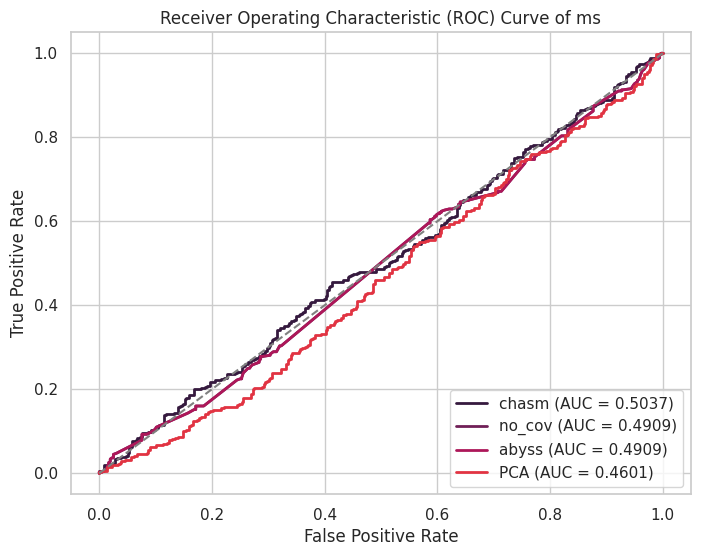

In [66]:
 # Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve for each PRS correction tool
for tool_name, tool_fpr, tool_tpr in zip(tools, tool_fprs, tool_tprs):
    roc_auc = auc(tool_fpr, tool_tpr)
    plt.plot(tool_fpr, tool_tpr, lw=2, label=f'{tool_name} (AUC = {roc_auc:.4f})')

# Plot the diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Receiver Operating Characteristic (ROC) Curve of {disease}")
plt.legend(loc='lower right')

# Extract new betas from the model 

In [ ]:
extracted_betas = []
for sub_model in sub_models:
    for layer in sub_model.layers:
        if isinstance(layer, CustomDenseLayer):
            weights = layer.get_weights()[0]  # Extract the weights
            extracted_betas.append(weights.flatten()) 

In [ ]:
extracted_betas

In [ ]:
new_genos = []
for i in range(len(snps_array)):
    snps_cluster = snps_array[i]
    geno = snps_cluster.iloc[:-1].copy()
    beta_temp = extracted_betas[i]
    new_genos.append(geno * beta_temp)

In [ ]:
combined_geno = pd.concat(new_genos, axis=1)

In [ ]:
combined_geno

In [ ]:
combined_geno

In [ ]:
pheno = pd.read_pickle(path_pheno + f"/{disease}.pkl")

In [ ]:
combined_geno['FID'] = list(id_samples['FID'])
genos = pd.merge(combined_geno, pheno[['FID','phenotype']], on='FID')
# Fit the scaler to the data and transform it
geno_scaled = scaler.fit_transform(geno)

# If you want the result as a pandas DataFrame
geno = pd.DataFrame(geno_scaled, columns=geno.columns)
filtered_columns = [col for col in genos.columns if col not in ['FID', 'phenotype']]

In [ ]:
snps = []
consts = []
effect_size_snps = []
effect_size_mafs = []
std_errs = []
ts = []
Ps = []
# Analyze each SNP
for snp_id in filtered_columns:
    snps.append(snp_id)
    # Concatenate genotype and MAF probability data for the SNP
    X = genos[[snp_id]]
    X2 = sm.add_constant(X)
    # Perform OLS regression
    est = sm.OLS(genos[['phenotype']], X2)
    est2 = est.fit()
    # Extract coefficients (betas)
    betas = est2.params            
    try:
        consts.append(betas['const'])
    except:
        consts.append(0)
    effect_size_snps.append(betas[snp_id])
    std_errs.append(est2.bse[snp_id])
    ts.append(est2.tvalues[snp_id])
        
    P = est2.pvalues[snp_id]
    Ps.append(P)
sumstat = pd.DataFrame(data={
'snp': snps,
'consts': consts,
'beta_snp': effect_size_snps,
'std_err': std_errs,
'Z': ts,
'P': Ps
})

In [ ]:
split_data = sumstat['snp'].str.split(':', expand=True)
chromosome = split_data[0]
position = split_data[1]
sumstat['#CHROM'] = chromosome.astype(int)
sumstat['POS'] = position.astype(int)
sumstat['POS'] = sumstat['POS'].astype(int)
sumstat['-logp'] = - np.log(sumstat['P'])

In [ ]:
# Setting the style to 'rocket' from seaborn
sns.set(style="white", palette="rocket")

In [ ]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for chasm filtered betas")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()

In [ ]:
new_genos = []
for i in range(len(snps_array)):
    snps_cluster = snps_array[i]
    geno = snps_cluster.iloc[:-1].copy()
    new_genos.append(geno)
combined_geno = pd.concat(new_genos, axis=1)
combined_geno['FID'] = list(id_samples['FID'])
genos = pd.merge(combined_geno, pheno[['FID','phenotype']], on='FID')
# Fit the scaler to the data and transform it
#geno_scaled = scaler.fit_transform(geno)
geno_scaled = genos
# If you want the result as a pandas DataFrame
geno = pd.DataFrame(geno_scaled, columns=geno.columns)
filtered_columns = [col for col in genos.columns if col not in ['FID', 'phenotype']]

In [ ]:
snps = []
consts = []
effect_size_snps = []
effect_size_mafs = []
std_errs = []
ts = []
Ps = []
# Analyze each SNP
for snp_id in filtered_columns:
    snps.append(snp_id)
    # Concatenate genotype and MAF probability data for the SNP
    X = genos[[snp_id]]
    X2 = sm.add_constant(X)
    # Perform OLS regression
    est = sm.OLS(genos[['phenotype']], X2)
    est2 = est.fit()
    # Extract coefficients (betas)
    betas = est2.params            
    try:
        consts.append(betas['const'])
    except:
        consts.append(0)
    effect_size_snps.append(betas[snp_id])
    std_errs.append(est2.bse[snp_id])
    ts.append(est2.tvalues[snp_id])
        
    P = est2.pvalues[snp_id]
    Ps.append(P)
sumstat = pd.DataFrame(data={
'snp': snps,
'consts': consts,
'beta_snp': effect_size_snps,
'std_err': std_errs,
'Z': ts,
'P': Ps
})

In [ ]:
split_data = sumstat['snp'].str.split(':', expand=True)
chromosome = split_data[0]
position = split_data[1]
sumstat['#CHROM'] = chromosome.astype(int)
sumstat['POS'] = position.astype(int)
sumstat['POS'] = sumstat['POS'].astype(int)
sumstat['-logp'] = - np.log(sumstat['P'])

In [ ]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for chasm filtered betas")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()

In [ ]:
geno

# Manhattan of the betas

In [ ]:
extracted_betas = []
for sub_model in sub_models:
    for layer in sub_model.layers:
        if isinstance(layer, CustomDenseLayer):
            weights = layer.get_weights()[0]  # Extract the weights
            extracted_betas.append(weights.flatten())

In [ ]:
snps = []
old_betas = []
new_betas = []

for i in range(len(snps_array)):
    snps_cluster = snps_array[i]
    geno = snps_cluster.iloc[:-1].copy()
    snps.append(list(geno.columns))
    betas = np.array(snps_cluster.iloc[-1])
    old_betas.append(list(betas))
    beta_updated = extracted_betas[i]
    new_betas.append(beta_updated)

In [ ]:
snps = [item for sublist in snps for item in sublist]
old_betas = [item for sublist in old_betas for item in sublist]
new_betas = [item for sublist in new_betas for item in sublist]

In [ ]:
# Create a DataFrame
sumstat = pd.DataFrame({
    'snp': snps,
    'Old_Betas': old_betas,
    'New_Betas': new_betas
})

In [ ]:
sumstat['Old_Betas'] = sumstat['Old_Betas'].abs()
sumstat['New_Betas'] = sumstat['New_Betas'].abs()

In [ ]:
split_data = sumstat['snp'].str.split(':', expand=True)
chromosome = split_data[0]
position = split_data[1]
sumstat['#CHROM'] = chromosome.astype(int)
sumstat['POS'] = position.astype(int)
sumstat['POS'] = sumstat['POS'].astype(int)

In [ ]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='Old_Betas',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"Old betas per SNPS")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", "Old Betas")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()

In [ ]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='New_Betas',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"New betas per SNPS")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", "New Betas")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()